In [1]:
import os
import platform
import sys

def get_project_root() -> str:
    system = platform.system()
    return r"D:\Users\tcshore\Documents\Projects\Tangrams\Data" if system == "Windows" else "/home/tshore/Projects/tangrams-restricted/Data"

infile_path = os.path.join(get_project_root(), "wordscores-inflected-small.tsv")
print("Will read file \"{}\".".format(infile_path), file=sys.stderr)

Will read file "D:\Users\tcshore\Documents\Projects\Tangrams\Data\wordscores-inflected-small.tsv".


In [2]:
import csv
import pandas as pd

RESULTS_FILE_CSV_DIALECT = csv.excel_tab
# NOTE: "category" dtype doesn't work with pandas-0.21.0 but does with pandas-0.21.1
__RESULTS_FILE_DTYPES = {"DYAD": "category", "ENTITY" : "category", "IS_TARGET": bool, "IS_OOV": bool,
				 "IS_INSTRUCTOR": bool, "SHAPE": "category", "ONLY_INSTRUCTOR": bool, "WEIGHT_BY_FREQ": bool}

def read_results_file(inpath: str, encoding: str) -> pd.DataFrame:
	print("Reading \"{}\" using encoding \"{}\".".format(inpath, encoding), file=sys.stderr)
	result = pd.read_csv(inpath, dialect=RESULTS_FILE_CSV_DIALECT, sep=RESULTS_FILE_CSV_DIALECT.delimiter,
						 float_precision="round_trip",
						 encoding=encoding, memory_map=True, dtype=__RESULTS_FILE_DTYPES)
	return result

cv_results = read_results_file(infile_path, "windows-1252")
print("Read {} cross-validation results for {} dyad(s).".format(cv_results.shape[0], cv_results["DYAD"].nunique()),
      file=sys.stderr)

Reading "D:\Users\tcshore\Documents\Projects\Tangrams\Data\wordscores-inflected-small.tsv" using encoding "windows-1252".
Read 67060 cross-validation results for 3 dyad(s).


In [3]:
def find_target_ref_rows(df: pd.DataFrame) -> pd.DataFrame:
	result = df.loc[df["IS_TARGET"] == True]
	result_row_count = result.shape[0]
	complement_row_count = df.loc[~df.index.isin(result.index)].shape[0]
	assert result_row_count + complement_row_count == df.shape[0]
	print("Found {} nontarget rows and {} target rows. Ratio: {}".format(complement_row_count, result_row_count,
																		 complement_row_count / float(
																			 result_row_count)), file=sys.stderr)
	return result

cv_results = find_target_ref_rows(cv_results)

Found 63707 nontarget rows and 3353 target rows. Ratio: 19.0


In [4]:
OOV_LABEL = "__OOV__"
    
print("Replacing OOV words with label \"{}\".".format(OOV_LABEL), file=sys.stderr)
cv_results.loc[cv_results["IS_OOV"] == True, "WORD"] = OOV_LABEL

Replacing OOV words with label "__OOV__".


In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#import numpy as np

# Create vocab before splitting training and testing DFs so that the word feature set is stable
print("Fitting one-hot encoder for vocabulary of size {}.".format(cv_results["WORD"].nunique()), file=sys.stderr)

# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
# integer encode
label_encoder = LabelEncoder()
vocab_labels = label_encoder.fit_transform(cv_results["WORD"])
cv_results["WORD_LABEL"] = vocab_labels
#print(vocab_labels)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
vocab_labels = vocab_labels.reshape(len(vocab_labels), 1)
onehot_encoder.fit(vocab_labels)
#assert onehot_encoder.n_values_ == len(vocab_words)
#vocab_onehot_encoded = onehot_encoder.fit_transform(vocab_labels)
#print(vocab_onehot_encoded)
# invert first example
#inverted = label_encoder.inverse_transform([np.argmax(vocab_onehot_encoded[0, :])])
#print(inverted)

Fitting one-hot encoder for vocabulary of size 249.


OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [6]:
from typing import Tuple

import numpy as np

def split_training_testing(df: pd.DataFrame, test_set_size : int) -> Tuple[pd.DataFrame, pd.DataFrame]:
	dyad_ids = df["DYAD"].unique()
	training_set_size = len(dyad_ids) - test_set_size
	if training_set_size < 1:
		raise ValueError("Desired test set size is {} but only {} dyads found.".format(test_set_size, len(dyad_ids)))
	else:
		training_set_dyads = frozenset(np.random.choice(dyad_ids, training_set_size))
		print("Training set dyads: {}".format(sorted(training_set_dyads)), file=sys.stderr)
		training_set_idxs = df["DYAD"].isin(training_set_dyads)
		training_set = df.loc[training_set_idxs]
		test_set = df.loc[~training_set_idxs]
		test_set_dyads = frozenset(test_set["DYAD"].unique())
		print("Test set dyads: {}".format(sorted(test_set_dyads)), file=sys.stderr)

		assert not frozenset(training_set["DYAD"].unique()).intersection(frozenset(test_set_dyads))
		return training_set, test_set
    
# https://stackoverflow.com/a/47815400/1391325
cv_results.sort_values("TOKEN_SEQ_ORDINALITY", inplace=True)
training_df, test_df = split_training_testing(cv_results, 1)
#training_df = training_df.copy(deep=False)
#test_df = test_df.copy(deep=False)

Training set dyads: ['20', '22']
Test set dyads: ['21']


In [22]:
from typing import Iterator, List, Mapping

import keras.preprocessing.sequence

class SequenceMatrixGenerator(object):

	def __init__(self, onehot_encoder):
		self.onehot_encoder = onehot_encoder

	@property
	def feature_count(self) -> int:
		word_features = self.onehot_encoder.n_values_[0]
		return word_features + 2

	def __create_datapoint_feature_array(self, row: pd.Series) -> Tuple[np.array]:
		# word_features = [0.0] * len(self.__vocab_idxs)
		# The features representing each individual vocabulary word are at the beginning of the feature vector
		# word_features[self.__vocab_idxs[row["WORD"]]] = 1.0
		# word_label = self.label_encoder.transform(row["WORD"])
		word_label = row["WORD_LABEL"]
		# print("Word label: {}".format(word_label), file=sys.stderr)
		# "OneHotEncoder.transform(..)" returns a matrix even if only a single value is passed to it, so get just the first (and only) row
		word_features = self.onehot_encoder.transform(word_label)[0]
		# print("Word features: {}".format(word_features), file=sys.stderr)
		# The word label for the one-hot encoding is that with the same index as the column that has a "1" value, i.e. the highest value in the vector of one-hot encoding values
		# inverse_label = np.argmax(word_features)
		# assert inverse_label == word_label
		# inverse_word = self.label_encoder.inverse_transform([inverse_label])
		# print("Inverse word label: {}".format(inverse_label), file=sys.stderr)
		is_instructor = 1.0 if row["IS_INSTRUCTOR"] else 0.0
		# is_target = 1.0 if row["IS_TARGET"] else 0.0
		score = row["PROBABILITY"]
		other_features = np.array((is_instructor, score))
		# result = word_features + other_features
		result = np.concatenate((word_features, other_features))
		# print("Created a vector of {} features.".format(len(result)), file=sys.stderr)
		# NOTE: Returning a tuple is a hack in order to return an instance of "np.ndarray" from "DataFrame.apply()"        
		return result,

	def __create_seq_feature_matrix(self, df: pd.DataFrame) -> np.matrix:
		# NOTE: The returned tuples have to be unpacked outside of the "apply(..)" function
		vectors = df.apply(self.__create_datapoint_feature_array, axis=1)        
		return np.matrix(tuple(vector[0] for vector in vectors))

	def __call__(self, df: pd.DataFrame) -> Iterator[np.matrix]:
		sequence_groups = df.groupby(
			("CROSS_VALIDATION_ITER", "DYAD", "UTT_START_TIME", "UTT_END_TIME", "ENTITY"),
			as_index=False, sort=False)
		return sequence_groups.apply(self.__create_seq_feature_matrix)

print("Splitting token sequences.", file=sys.stderr)
seq_matrix_generator = SequenceMatrixGenerator(onehot_encoder)
training_seqs = tuple(seq_matrix_generator(training_df))
max_training_seq_len = max(m.shape[0] for m in training_seqs)
print("Created a training dataset with a size of {} and a max sequence length of {}.".format(len(training_seqs), max_training_seq_len), file=sys.stderr)
test_seqs = tuple(seq_matrix_generator(test_df))
max_test_seq_len = max(m.shape[0] for m in test_seqs)
print("Created a test dataset with a size of {} and a max sequence length of {}.".format(len(test_seqs), max_test_seq_len), file=sys.stderr)

maxlen = max(max_training_seq_len, max_test_seq_len)
print("Padding sequences to a length of {}.".format(maxlen), file=sys.stderr)
training_matrix = keras.preprocessing.sequence.pad_sequences(training_seqs, maxlen=maxlen, padding='pre', truncating='pre', value=0.)
print("Batch training matrix shape: {}".format(training_matrix.shape), file=sys.stderr)
test_matrix = keras.preprocessing.sequence.pad_sequences(test_seqs, maxlen=maxlen, padding='pre', truncating='pre', value=0.)
print("Batch test matrix shape: {}".format(test_matrix.shape), file=sys.stderr)

Splitting token sequences.
Created a training dataset with a size of 291 and a max sequence length of 40.
Created a test dataset with a size of 125 and a max sequence length of 33.
Padding sequences to a length of 40.
Batch training matrix shape: (291, 40, 251)
Batch test matrix shape: (125, 40, 251)


In [36]:
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential

def split_xy(matrix : np.array) -> Tuple[np.array, np.array]:
    x = matrix[:, :, :-1]
    assert len(x.shape) == 3
    y = matrix[:, :, -1]
    assert len(y.shape) == 2
    return x, y

def create_model(training_x: np.ndarray, training_y: np.ndarray) -> Sequential:
	result = Sequential()
	# word_embeddings = Embedding(len(vocab), embedding_vector_length, input_length=max_review_length)
	# model.add(word_embeddings)
	# model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
	# input shape is a pair of (timesteps, features) <https://stackoverflow.com/a/44583784/1391325>
	input_shape = training_x.shape[1:]
	print("Input shape: {}".format(input_shape), file=sys.stderr)
	units = training_y.shape[1]
	print("Units: {}".format(units), file=sys.stderr)
	lstm = LSTM(input_shape=input_shape, units=units)
	# lstm = LSTM(batch_input_shape = training_x.shape, stateful = True, units=len(training_y.shape))
	result.add(lstm)
	result.add(Dense(units, activation='sigmoid'))
	result.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	print(result.summary())
	return result

training_x, training_y = split_xy(training_matrix)
print("Training X shape: {}".format(training_x.shape), file=sys.stderr)
print("Training Y shape: {}".format(training_y.shape), file=sys.stderr)
model = create_model(training_x, training_y)

Training X shape: (291, 40, 250)
Training Y shape: (291, 40)
Input shape: (40, 250)
Units: 40


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 40)                46560     
_________________________________________________________________
dense_7 (Dense)              (None, 40)                1640      
Total params: 48,200
Trainable params: 48,200
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# train LSTM

#import keras.utils
#import math

#class CIFAR10Sequence(keras.utils.Sequence):

#    def __init__(self, x_set, y_set, batch_size):
#        self.x, self.y = x_set, y_set
#        self.batch_size = batch_size

#    def __len__(self):
#        return math.ceil(len(self.x) / self.batch_size)

#    def __getitem__(self, idx):
#        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
#        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
#        return np.array(batch_x), np.array(batch_y)
    
#training_data_generator = CIFAR10Sequence(training_x, training_y, 32)

test_x, test_y = split_xy(test_matrix)
print("Training X shape: {}".format(test_x.shape), file=sys.stderr)
print("Training Y shape: {}".format(test_y.shape), file=sys.stderr)

#model.fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
#training_history = model.fit(training_x, training_y, epochs=1, verbose=1, validation_data=(test_x, test_y))
training_history = model.fit(training_x, training_y, epochs=50, verbose=0, validation_data=(test_x, test_y))
#for seq_idx in range(0, len(training_x)):
#   seq_x = training_x[seq_idx]
#    print(seq_x.shape)
#    seq_y = training_y[seq_idx]
#    print(seq_y.shape)
#    print(training_matrix.shape)
#    training_x = np.array([training_matrix[:, :-1]])
#print(training_x.shape)
#    assert len(training_x.shape) == 3
#    training_y = np.array([training_matrix[:, -1]])
#print(training_y.shape)
#    assert len(training_y.shape) == 3
#    training_history = model.fit(x=training_x, y=training_y, epochs=1, verbose=1, batch_size=1)
#    training_history = model.fit(x=seq_x, y=seq_y, epochs=1, verbose=1)
#fit_generator(self, generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
#training_history = model.fit_generator(training_data_generator, epochs=1, verbose=1)

# train LSTM <https://machinelearningmastery.com/memory-in-a-long-short-term-memory-network/>
#epochs = 5
#for i in range(epochs):
#    for seq_idx in range(0, training_x.shape[0]):
        #x = training_x[i]
#        x = training_x[0:31]
 #       x_oldshape = x.shape
 #       x_newshape = (-1, x_oldshape[0], x_oldshape[1])
        #x = np.reshape(x, x_newshape)
        #print("x.shape = {}".format(x.shape), file=sys.stderr)
        #y = training_y[i]
 #       y = training_y[0:31]
 #       y_oldshape = y.shape
 #       y_newshape = (-1, y_oldshape[0])
        #y = np.reshape(y, y_newshape)
        #print("y.shape = {}".format(y.shape), file=sys.stderr)
 #       model.fit(x, y, epochs=1, batch_size=1, verbose=1, shuffle=False)
 #       model.reset_states()
    
    

Training X shape: (125, 40, 250)
Training Y shape: (125, 40)


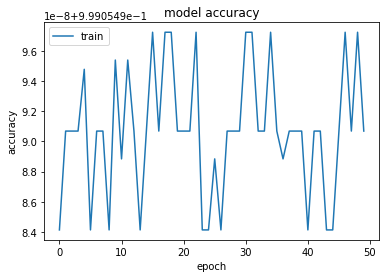

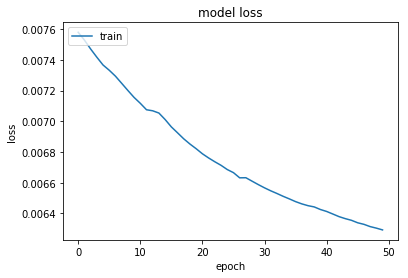

In [42]:
import matplotlib.pyplot as plt

# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# list all data in history
#print(training_history.history.keys())
# summarize history for accuracy
plt.plot(training_history.history['acc'])
plt.plot(training_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# test LSTM

def onehot_encodings(features : np.array, onehot_encoder) -> np.array:
    """
    :param features: A 2D array of feature vectors, each of which starts with one-hot encoding features. Any other features follow those.
    :param onehot_encoder: The instance used to encode the original values.
    :return: A 2D numpy array consisting only of one-hot encoding features.
    """
    feature_count = onehot_encoder.n_values_[0]
    return features[:,:feature_count + 1]


test_x = test_matrix[:,:,:-1]
print(test_x.shape)
assert len(test_x.shape) == 3
test_y = test_matrix[:,:,-1]
print(test_y.shape)
assert len(test_y.shape) == 2

seq_predicted_values = model.predict(test_x, verbose=0)
model.reset_states()
#print("result.shape = {}".format(seq_predicted_values.shape), file=sys.stderr)
for i, tested_seq in enumerate(test_x):
    word_features = onehot_encodings(tested_seq, onehot_encoder)
    #print("word features: {}".format(word_features))
    #print("Tested sequence: {}".format(tested_seq))
    #print("Tested sequence shape: {}".format(tested_seq.shape))
    seq_labels = word_features.argmax(axis=1)
    #print("Inverse labels: {}".format(inverse_labels))
    seq_words = label_encoder.inverse_transform(seq_labels)
    print("Inverse word labels: {}".format(seq_words))
    predicted_values = seq_predicted_values[i]
    assert tested_seq.shape[:-1] == predicted_values.shape
    #assert tested_seq.shape[:-1] == actual_values.shape
    #rint("Predicted values: {}".format(predicted_values))
    actual_values = test_y[i]
    assert predicted_values.shape == actual_values.shape
    
    differences = predicted_values - actual_values
    print("[Predicted_val - Actual_val]: {}".format(differences))
    #print("Actual values: {}".format(actual_values))
	#print('X=%.1f y=%.1f, yhat=%.1f' % (seq1[i], seq1[i+1], result[i]))